In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.util import bigrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from nltk.probability import FreqDist

from textblob import TextBlob
import re
import string

/home/joaogarcia/Documents/DataScience/venv/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joaogarcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/joaogarcia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
## Lendo os dados e doprando a coluna ID, que não vai ajudar em nada nessa análise
data = pd.read_csv('./Dataset/NLP_Data.csv', index_col=0, dtype={'General Features': object})
data.drop(columns=['ID'], inplace=True)
data.head()

,Website,Product,Brand,URL,Description,Technical Features,General Features,Comment#1,Comment#2,Rating,Available Colors,No. Colors
0,lowes,Refrigerators,General Electric,https://www.lowes.com/pd/GE-25-1-cu-ft-Side-by...,GE 25.1-cu ft Side-by-Side Refrigerator with I...,'25.1':2 'black':13 'by':7 'cu':3 'ft':4 'ge':...,"{'brand': ['GE', 'Ge'], 'model': ['GSS25IBNTS'...",Functional,Pros: fingerprint resistant so you don't have ...,3.0,"['1000859768', '1000859852']",2
1,lowes,Refrigerators,Frigidaire,https://www.lowes.com/pd/Frigidaire-Gallery-21...,Frigidaire Gallery 21.7-cu ft Counter-depth Fr...,'21.7':3 'counter':7 'counter-depth':6 'cu':4 ...,"{'brand': ['Frigidaire', 'Frigidaire'], 'model...",Ample Door Storage User Friendly Visibility,Feels solid and “upscale”. Excellent design of...,5.0,['1000289721'],1
2,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'bottom':6 'bottom-freezer':5 'cu':3 ...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",So much room,I love this fridge. So much room over having a...,5.0,"['3928039', '3928048', '3979801', '6112639']",4
3,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'black':9 'bottom':6 'bottom-freezer'...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",So much room,I love this fridge. So much room over having a...,5.0,"['3928039', '3928048', '3979801', '6112639']",4
4,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-22-1-cu...,Whirlpool - 22.1 Cu. Ft. Bottom-Freezer Refrig...,'22.1':2 'black':9 'bottom':6 'bottom-freezer'...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",So much room,I love this fridge. So much room over having a...,5.0,"['3928039', '3928048', '3979801', '6112639']",4


## 1- Limpar e arrumar conjunto de texto

### 1.1 - Limpando Valores Nulos e Duplicados

In [3]:
data.fillna('', inplace=True)
data.isnull().sum()

Website               0
Product               0
Brand                 0
URL                   0
Description           0
Technical Features    0
General Features      0
Comment#1             0
Comment#2             0
Rating                0
Available Colors      0
No. Colors            0
dtype: int64

In [4]:
len(data[data.duplicated() == True])

68

In [5]:
data.drop_duplicates(inplace=True)
data.reset_index(drop= True, inplace=True)
data.head()

,Website,Product,Brand,URL,Description,Technical Features,General Features,Comment#1,Comment#2,Rating,Available Colors,No. Colors
0,lowes,Refrigerators,General Electric,https://www.lowes.com/pd/GE-25-1-cu-ft-Side-by...,GE 25.1-cu ft Side-by-Side Refrigerator with I...,'25.1':2 'black':13 'by':7 'cu':3 'ft':4 'ge':...,"{'brand': ['GE', 'Ge'], 'model': ['GSS25IBNTS'...",Functional,Pros: fingerprint resistant so you don't have ...,3.0,"['1000859768', '1000859852']",2
1,lowes,Refrigerators,Frigidaire,https://www.lowes.com/pd/Frigidaire-Gallery-21...,Frigidaire Gallery 21.7-cu ft Counter-depth Fr...,'21.7':3 'counter':7 'counter-depth':6 'cu':4 ...,"{'brand': ['Frigidaire', 'Frigidaire'], 'model...",Ample Door Storage User Friendly Visibility,Feels solid and “upscale”. Excellent design of...,5.0,['1000289721'],1
2,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'bottom':6 'bottom-freezer':5 'cu':3 ...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",So much room,I love this fridge. So much room over having a...,5.0,"['3928039', '3928048', '3979801', '6112639']",4
3,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'black':9 'bottom':6 'bottom-freezer'...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",So much room,I love this fridge. So much room over having a...,5.0,"['3928039', '3928048', '3979801', '6112639']",4
4,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-22-1-cu...,Whirlpool - 22.1 Cu. Ft. Bottom-Freezer Refrig...,'22.1':2 'black':9 'bottom':6 'bottom-freezer'...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",So much room,I love this fridge. So much room over having a...,5.0,"['3928039', '3928048', '3979801', '6112639']",4


### 1.2 - Limpar o Texto. Pontuações, tudo em letra minúscula, stopwords, etc.

In [6]:
def remove_stop_words(text, stopwords):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords]
    text = ' '.join(tokens_without_sw)
    return text

In [7]:
def clean_text(text, stopwords):
    text = text.lower()
    
    # Remove palavras entre colchetes
    text = re.sub('\[.*?\]', '', text)
    
    #remove palavras com numero
    text = re.sub('\w*\d\w*', '', text)
    
    #remove pontuação
    punctuation = '[' + re.escape(string.punctuation) +'\\”\\“\\’'+']'
    text = re.sub(punctuation, '', text)
    
    #remove stop words
    text = remove_stop_words(text, stopwords)
    return text

In [8]:
en_stopwords = stopwords.words('english')

new_words = ['aahs', 'etc', 'yrs', 'weve', 'yoy', 'cu', 'ft', 'every','time', 'ive', 'im','youve', 'theres', 'youre', 'son', 'young', 'youll', 'aboveand', 'yin', 'yo', 'youl']
for word in new_words:
    en_stopwords.append(word)

In [9]:
## Limpando os dois comentários
col_name = ['Comment#1', 'Comment#2']
data['Comment#1'] = data.apply(lambda x: clean_text(x[col_name[0]], en_stopwords), axis=1 )
data['Comment#2'] = data.apply(lambda x: clean_text(x[col_name[1]], en_stopwords), axis=1 )
data['Comment#2'][1]

'feels solid upscale excellent design door shelves allow depth easy visibility ditto storage drawers freezer love dual ice makers look enjoy fridge long'

### 1.3 - Juntar os dois tipos de comentário em um só

In [10]:
col_names = ['Comment#1', 'Comment#2']
data['Full_Comment'] = data.apply(lambda x: x[col_names[0]] + ' ' + x[col_names[1]], axis=1)
data.head(5)

,Website,Product,Brand,URL,Description,Technical Features,General Features,Comment#1,Comment#2,Rating,Available Colors,No. Colors,Full_Comment
0,lowes,Refrigerators,General Electric,https://www.lowes.com/pd/GE-25-1-cu-ft-Side-by...,GE 25.1-cu ft Side-by-Side Refrigerator with I...,'25.1':2 'black':13 'by':7 'cu':3 'ft':4 'ge':...,"{'brand': ['GE', 'Ge'], 'model': ['GSS25IBNTS'...",functional,pros fingerprint resistant dont constantly wip...,3.0,"['1000859768', '1000859852']",2,functional pros fingerprint resistant dont con...
1,lowes,Refrigerators,Frigidaire,https://www.lowes.com/pd/Frigidaire-Gallery-21...,Frigidaire Gallery 21.7-cu ft Counter-depth Fr...,'21.7':3 'counter':7 'counter-depth':6 'cu':4 ...,"{'brand': ['Frigidaire', 'Frigidaire'], 'model...",ample door storage user friendly visibility,feels solid upscale excellent design door shel...,5.0,['1000289721'],1,ample door storage user friendly visibility fe...
2,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'bottom':6 'bottom-freezer':5 'cu':3 ...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...
3,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'black':9 'bottom':6 'bottom-freezer'...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...
4,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-22-1-cu...,Whirlpool - 22.1 Cu. Ft. Bottom-Freezer Refrig...,'22.1':2 'black':9 'bottom':6 'bottom-freezer'...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...


## 2 - Avaliando Sentimento usando TextBlob Sentiment Package

In [11]:
col_name = ['Full_Comment']
## Criando duas novas colunas para cada comentário: polarity e subjectivity
data['polarity'] = data.apply(lambda x: TextBlob(x[col_name[0]]).sentiment.polarity, axis=1 )
data['subjectivity'] = data.apply(lambda x: TextBlob(x[col_name[0]]).sentiment.subjectivity, axis=1 )
data.head(5)

,Website,Product,Brand,URL,Description,Technical Features,General Features,Comment#1,Comment#2,Rating,Available Colors,No. Colors,Full_Comment,polarity,subjectivity
0,lowes,Refrigerators,General Electric,https://www.lowes.com/pd/GE-25-1-cu-ft-Side-by...,GE 25.1-cu ft Side-by-Side Refrigerator with I...,'25.1':2 'black':13 'by':7 'cu':3 'ft':4 'ge':...,"{'brand': ['GE', 'Ge'], 'model': ['GSS25IBNTS'...",functional,pros fingerprint resistant dont constantly wip...,3.0,"['1000859768', '1000859852']",2,functional pros fingerprint resistant dont con...,0.250000,0.645833
1,lowes,Refrigerators,Frigidaire,https://www.lowes.com/pd/Frigidaire-Gallery-21...,Frigidaire Gallery 21.7-cu ft Counter-depth Fr...,'21.7':3 'counter':7 'counter-depth':6 'cu':4 ...,"{'brand': ['Frigidaire', 'Frigidaire'], 'model...",ample door storage user friendly visibility,feels solid upscale excellent design door shel...,5.0,['1000289721'],1,ample door storage user friendly visibility fe...,0.379762,0.561905
2,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'bottom':6 'bottom-freezer':5 'cu':3 ...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...,0.219048,0.271429
3,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'black':9 'bottom':6 'bottom-freezer'...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...,0.219048,0.271429
4,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-22-1-cu...,Whirlpool - 22.1 Cu. Ft. Bottom-Freezer Refrig...,'22.1':2 'black':9 'bottom':6 'bottom-freezer'...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...,0.219048,0.271429


### 2.1 - Avaliando Polaridade para cada Marca

In [12]:
## as 10 marcas com mais produtos no dataset
num_products_per_brand = data.groupby(['Brand'])['Product'].count().sort_values(ascending=False)
ten_most_brands = num_products_per_brand.head(10)
ten_most_brands

Brand
Whirlpool           6602
General Electric    4886
Frigidaire          2890
Samsung             1854
LG                  1784
Kitchenaid           837
Maytag               436
Cafe                 303
Insignia™            161
Magic Chef           120
Name: Product, dtype: int64

In [13]:
## Dessas 10 maiores marcas, pegando a média de polaridade de cada uma delas
brands_mean_polarity = data.groupby('Brand')['polarity'].mean()
ten_most_brands = brands_mean_polarity.loc[ten_most_brands.index]
ten_most_brands

Brand
Whirlpool           0.298125
General Electric    0.286678
Frigidaire          0.292159
Samsung             0.288977
LG                  0.256354
Kitchenaid          0.314610
Maytag              0.263281
Cafe                0.269668
Insignia™           0.275634
Magic Chef          0.283532
Name: polarity, dtype: float64

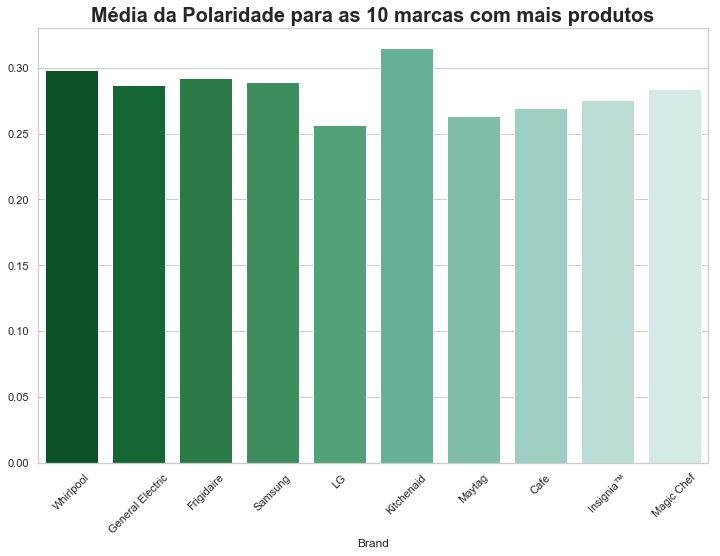

In [14]:
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")

plt.title('Média da Polaridade para as 10 marcas com mais produtos', fontdict={'fontsize': 20, 'fontweight': 'bold'})

barplot = sns.barplot(x=ten_most_brands.index, 
            y=ten_most_brands.values,
            palette=sns.color_palette('BuGn_r', n_colors=len(ten_most_brands)+2))
plt.xticks(rotation=45)
plt.show()

### 2.2 - Avaliando Polaridade para cada Website

In [15]:
## os 10 websites com mais produtos no dataset
num_products_per_website = data.groupby(['Website'])['Product'].count().sort_values(ascending=False)
ten_most_websites = num_products_per_website.head(10)
ten_most_websites

Website
lowes              9478
homedepot          4041
bestbuy_us         2406
whirlpool          1241
walmart_us          987
costco_us           738
ge_appliance_us     490
lg_us               453
samsclub            196
maytag              187
Name: Product, dtype: int64

In [16]:
## Desses 10 maiores sites, pegando a média de polaridade de cada um deles
sites_mean_polarity = data.groupby('Website')['polarity'].mean()
ten_most_websites = sites_mean_polarity.loc[ten_most_websites.index]
ten_most_websites

Website
lowes              0.297245
homedepot          0.275205
bestbuy_us         0.304021
whirlpool          0.265460
walmart_us         0.284427
costco_us          0.278162
ge_appliance_us    0.262334
lg_us              0.239062
samsclub           0.287552
maytag             0.267178
Name: polarity, dtype: float64

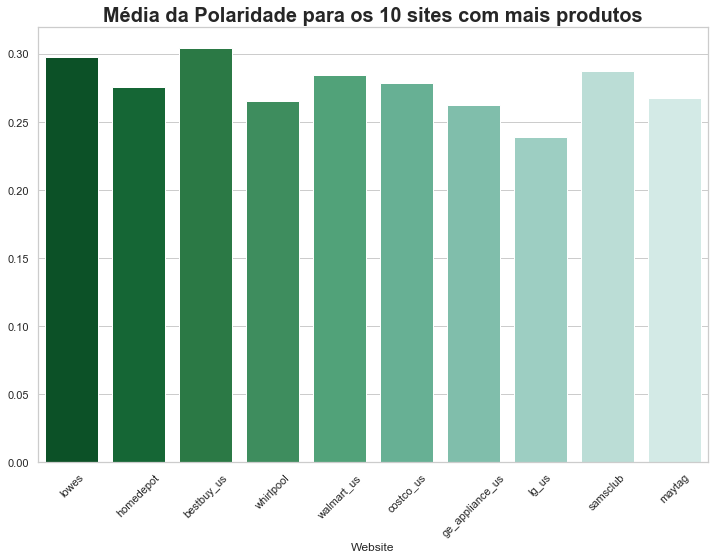

In [17]:
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")

plt.title('Média da Polaridade para os 10 sites com mais produtos', fontdict={'fontsize': 20, 'fontweight': 'bold'})

barplot = sns.barplot(x=ten_most_websites.index, 
            y=ten_most_websites.values,
            palette=sns.color_palette('BuGn_r', n_colors=len(ten_most_websites)+2))
plt.xticks(rotation=45)
plt.show()

### 2.3 - Avaliando Polaridade para cada Modelo de geladeira

In [18]:
def get_features(general_features):

    features = {}
    count = 0

    x = general_features.split('], ')
    for string in x:
        y = string.strip('{}')
        if(y.find('"') == -1):
            y = y.split("': ")
        else:
            y = y.split('": ')
        #print(y)
        for text in y:
            if(count==0):
                count=1
                if(text.strip(" '") == 'title'):
                    count= 0 
                    continue
                if(text.find('[') == -1):
                    chave = text.strip(" '").lower()
                    features[chave]=None
            else:
                count=0
                if(text.find('[') == -1):
                    continue
                else:
                    value = text.strip('[ ').split(',')
                    features[chave] = value
    for chave, value in features.items():
        if(chave.find('unspsc') != -1):
            features['unspsc'] = features.pop(chave)
            break
    return features

In [19]:
## Transformando a coluna General Features que é uma string em um dicionário com chaves e valores

temp = data.copy()
general_features = data['General Features']
count = 0
for row in general_features:
    features = get_features(row)
    temp.at[count, 'General Features'] =  features
    count+=1

In [20]:
## Separando somente aqueles produtos que tem a informação de modelo na coluna General Features
## As vezes esse modelo é uma lista de dois valores, mas eles em geral são iguais, por isso só pega a posição 0

col_name = ['General Features']
temp['Model'] = temp.apply(lambda x: 'model' in x[col_name[0]].keys(), axis=1)
data_w_model = temp.loc[temp['Model'] == True]
data_w_model['Model'] = data_w_model.apply(lambda x: x[col_name[0]]['model'][0], axis =1)

/home/joaogarcia/Documents/DataScience/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [21]:
## os 10 modelos com mais produtos no dataset
num_products_per_model = data_w_model.groupby(['Model'])['Product'].count().sort_values(ascending=False)
ten_most_models = num_products_per_model.head(10)
ten_most_models

Model
'WRX735SDHZ'    141
'FFHB2750TD'    116
'GFE26JBMTS'    110
'FFSS2615TD'    105
'FFSS2615TS'    104
'FFSS2615TP'    103
'WRF535SWHZ'     95
'WRX735SDHW'     88
'FFTR1814TW'     87
'WRX735SDHV'     87
Name: Product, dtype: int64

In [22]:
## Desses 10 modelos, egando a média de polaridade de cada um deles
models_mean_polarity = data_w_model.groupby('Model')['polarity'].mean()
ten_most_models = models_mean_polarity.loc[ten_most_models.index].sort_values(ascending=False)
ten_most_models

Model
'WRF535SWHZ'    0.343611
'WRX735SDHW'    0.340473
'WRX735SDHV'    0.338783
'FFHB2750TD'    0.337564
'WRX735SDHZ'    0.310292
'FFSS2615TD'    0.298022
'FFSS2615TP'    0.296507
'FFSS2615TS'    0.296080
'FFTR1814TW'    0.287678
'GFE26JBMTS'    0.264681
Name: polarity, dtype: float64

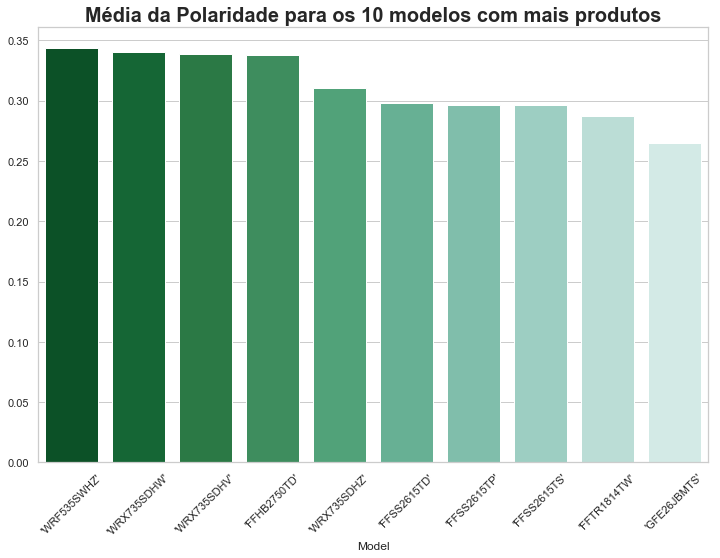

In [23]:
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")

plt.title('Média da Polaridade para os 10 modelos com mais produtos', fontdict={'fontsize': 20, 'fontweight': 'bold'})

barplot = sns.barplot(x=ten_most_models.index, 
            y=ten_most_models.values,
            palette=sns.color_palette('BuGn_r', n_colors=len(ten_most_models)+2))
plt.xticks(rotation=45)
plt.show()

In [24]:
## Retirando também a média de Rating para esses modelos

models_mean_rating = data_w_model.groupby('Model')['Rating'].mean()
models_mean_rating.loc[ten_most_models.index].sort_values(ascending=False)

Model
'WRX735SDHW'    4.534091
'WRX735SDHV'    4.528736
'WRF535SWHZ'    4.526316
'FFHB2750TD'    4.379310
'WRX735SDHZ'    4.333333
'FFTR1814TW'    4.321839
'GFE26JBMTS'    4.163636
'FFSS2615TP'    4.126214
'FFSS2615TD'    4.123810
'FFSS2615TS'    4.115385
Name: Rating, dtype: float64

### 2.4 - Avaliando o Modelo WRX735SDHZ - que tem a terceira melhor média de rating, e a primeira em polaridade, e é o modelo com mais comentários no dataset

In [25]:
WRX735SDHZ_info = data_w_model.loc[data_w_model['Model'] == "'WRX735SDHZ'" ]
WRX735SDHZ_info.reset_index(drop=True, inplace=True)

In [26]:
WRX735SDHZ_info['Website'].unique()

array(['costco_us', 'lowes'], dtype=object)

In [27]:
WRX735SDHZ_info['Brand'].unique()

array(['Whirlpool'], dtype=object)

In [28]:
WRX735SDHZ_info['URL'].unique()

array(['https://www.costco.com/.product.100378272.html?intl=nosplash',
       'https://www.lowes.com/pd/Whirlpool-24-5-cu-ft-4-Door-French-Door-Refrigerator-with-Ice-Maker-Fingerprint-Resistant-Stainless-Steel-ENERGY-STAR/1000257811'],
      dtype=object)

In [29]:
WRX735SDHZ_info['Description'].unique()

array(['Whirlpool 25CuFt 36-inch Wide French Door Refrigerator with Accu-Chill Management System, Fingerprint Resistant Stainless Steel',
       'Whirlpool 24.5-cu ft 4-Door French Door Refrigerator with Ice Maker (Fingerprint-Resistant Stainless Steel) ENERGY STAR'],
      dtype=object)

In [30]:
WRX735SDHZ_info['Technical Features'].unique()

array(["'25cuft':2 '36':3 'accu':11 'accu-chill':10 'chill':12 'door':7 'fingerprint':15 'french':6 'inch':4 'management':13 'refrigerator':8 'resistant':16 'stainless':17 'steel':18 'system':14 'whirlpool':1 'wide':5 'with':9",
       "'24.5':2 '4':5 'cu':3 'door':6,8 'energy':18 'fingerprint':14 'fingerprint-resistant':13 'french':7 'ft':4 'ice':11 'maker':12 'refrigerator':9 'resistant':15 'stainless':16 'star':19 'steel':17 'whirlpool':1 'with':10"],
      dtype=object)

In [31]:
WRX735SDHZ_info['General Features'][0]

{'brand': ["'whirlpool'"],
 'color': ["'Stainless Steel'"],
 'model': ["'WRX735SDHZ'"],
 'weight': ["'336 lb.'"],
 'features': ["'Water Filter'"],
 'fit width': ["'34 - 36 in.'"],
 'model number': ["'WRX735SDHZ'"],
 'model_number': ["'WRX735SDHZ'"],
 'warranty type': ["'Appliances'"],
 'freezer capacity': ["'6.73 cu. ft.'"],
 'freezer features': ["'Interior LED Lighting'"],
 'overall capacity': ["'20 - 24.9 cu. ft.'"],
 'refrigerator type': ["'French Door'"],
 'dimensions (wxdxh)': ["'36 in. x 35 in. x 70 in.'"],
 'refrigerator capacity': ["'17.78 cu. ft.'"],
 'refrigerator features': ["'Water Filter'"],
 'refrigerator shelf material': ["'Glass'"],
 'dimensions - w/ door open 90° (wxdxh)': ["'41 in. x 48 in. x 70.13 in.'"],
 'dimensions - w/o hinges & door (wxdxh)': ["'35.63 in. x 29 in. x 68.63 in.'"],
 'dimensions - w/ door & w/o handles (wxdxh)': ["'70.13 in. x 32.13 in. x 35.63 in.'"],
 'dimensions - w/ hinges, handles & door (wxdxh)': ["'35.63 in. x 34.63 in. x 70.13 in.']"]}

## 3 - Extraindo Features que andam falando sobre esse modelo

In [32]:
## Retirando mais palavras do texto, palavras que tem sentido mais subjetivo 
## e que em geral não se referem tanto a características do produto
new_words = ['lol', 'love', 'bought', 'love', 'isnt', 'get', 'would', 'family', 'great', 'nice', 'im', 'fridge', 'like', 'lot', 'happy', 'good', 'sure', 'best']
for word in new_words:
    en_stopwords.append(word)

In [33]:
def combine_text(full_text, text):
    full_text += ' '+text
    return full_text

In [34]:
## Juntando todos os comentários e removendo as stopwords

full_text = ''

for row in WRX735SDHZ_info.index:
    text = WRX735SDHZ_info.loc[row, 'Full_Comment']
    full_text = combine_text(full_text, text)
full_text = remove_stop_words(full_text, en_stopwords)

In [35]:
## Tokenizando o texto, calculando a frequência utilizando bigramas e a porcentagem de aparição das palavras
tokens = word_tokenize(full_text)
bgs = nltk.bigrams(tokens)
fdist = FreqDist(bgs)
for key, value in fdist.most_common(30):
    print('{}: {:.3f}' .format(key, value/len(WRX735SDHZ_info)) )

('ice', 'maker'): 0.220
('extra', 'drawer'): 0.092
('side', 'side'): 0.078
('french', 'door'): 0.071
('left', 'door'): 0.071
('weeks', 'ago'): 0.064
('middle', 'drawer'): 0.064
('freezer', 'drawer'): 0.057
('month', 'ago'): 0.057
('much', 'room'): 0.043
('water', 'ice'): 0.043
('refrigerator', 'month'): 0.043
('lots', 'space'): 0.043
('deli', 'drawer'): 0.043
('right', 'side'): 0.035
('pull', 'drawer'): 0.035
('plenty', 'room'): 0.035
('door', 'doesnt'): 0.035
('drawer', 'perfect'): 0.035
('side', 'door'): 0.035
('lots', 'room'): 0.028
('bit', 'noisy'): 0.028
('annoyingly', 'loud'): 0.028
('drawer', 'warped'): 0.028
('easy', 'access'): 0.028
('still', 'getting'): 0.028
('getting', 'used'): 0.028
('refrigerator', 'one'): 0.028
('new', 'one'): 0.028
('door', 'refrigerator'): 0.028


### INSIGHTS:

Olhando essa palavras, e a porcentagem com que elas aparecem:
- A palavra **ice maker** apareceu em 22% dos comentários
- Temos algumas palavras relacionadas a barulho:
   - **bit noisy** apareceu em 2.8%, **annoyingly loud** (2.8%)
- Temos muitas palavras com relação aos drawers:
    - **extra drawer**(9.2%), **middle drawer**(6,4%), **freezer drawer** (5,7%), **deli drawer** (4,3%)
- Temos palavras relacionadas ao espaço:
    - como **much room**, **lots space**, **lots room**, **plenty room**

#### A partir disso podemos supor algumas coisas
- A galera elogia bastante os drawers desse modelo, seja ele qualquer tipo de drawer que tenha na geladeira. E também o espaço disponível pela geladeira
- Porém tem algumas reclamações com relação ao barulho

## 4 - Extraindo Features baseado em Marcas/Websites

### 4.1 - Whirlpool

In [36]:
whirlpool_data = data.loc[data['Brand'] == 'Whirlpool']
whirlpool_data.head()

,Website,Product,Brand,URL,Description,Technical Features,General Features,Comment#1,Comment#2,Rating,Available Colors,No. Colors,Full_Comment,polarity,subjectivity
2,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'bottom':6 'bottom-freezer':5 'cu':3 ...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...,0.219048,0.271429
3,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'black':9 'bottom':6 'bottom-freezer'...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...,0.219048,0.271429
4,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-22-1-cu...,Whirlpool - 22.1 Cu. Ft. Bottom-Freezer Refrig...,'22.1':2 'black':9 'bottom':6 'bottom-freezer'...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...,0.219048,0.271429
5,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'bottom':6 'bottom-freezer':5 'cu':3 ...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...,0.219048,0.271429
9,costco_us,Refrigerators,Whirlpool,https://www.costco.com/.product.100369172.html...,Whirlpool 28CuFt Side-by-Side Refrigerator in ...,'28cuft':2 'and':16 'by':5 'dispenser':18 'eve...,"{'Brand': ['Whirlpool'], 'Color': ['Stainless ...",good product,bought product office pretty good exception wa...,4.0,['100369172'],1,good product bought product office pretty good...,0.550000,0.733333


In [37]:
## Juntando todos os comentários e removendo as stopwords

full_text = ''

for row in whirlpool_data.index:
    text = whirlpool_data.loc[row, 'Full_Comment']
    full_text = combine_text(full_text, text)
full_text = remove_stop_words(full_text, en_stopwords)

In [38]:
## Tokenizando o texto, calculando a frequência utilizando bigramas e a porcentagem de aparição das palavras
tokens = word_tokenize(full_text)
bgs = nltk.bigrams(tokens)
fdist = FreqDist(bgs)
for key, value in fdist.most_common(30):
    print('{}: {:.3f}' .format(key, value/len(whirlpool_data)) )

('ice', 'maker'): 0.188
('side', 'side'): 0.084
('weeks', 'ago'): 0.060
('month', 'ago'): 0.059
('water', 'dispenser'): 0.048
('french', 'door'): 0.043
('lots', 'room'): 0.043
('ice', 'water'): 0.043
('stainless', 'steel'): 0.036
('water', 'ice'): 0.034
('old', 'one'): 0.033
('plenty', 'room'): 0.031
('new', 'refrigerator'): 0.029
('freezer', 'bottom'): 0.027
('bottom', 'freezer'): 0.027
('year', 'old'): 0.025
('much', 'room'): 0.025
('works', 'well'): 0.024
('months', 'ago'): 0.023
('freezer', 'door'): 0.023
('freezer', 'space'): 0.022
('refrigerator', 'refrigerator'): 0.021
('lots', 'space'): 0.020
('door', 'shelves'): 0.020
('door', 'refrigerator'): 0.020
('whirlpool', 'refrigerator'): 0.020
('top', 'shelf'): 0.019
('easy', 'access'): 0.019
('old', 'refrigerator'): 0.018
('new', 'one'): 0.018


## 4.1.1 Quais caraterísticas aparecem em ratings mais baixos?

In [39]:
whirlpool_data_bad = whirlpool_data.loc[whirlpool_data['Rating'] <=2]
whirlpool_data_bad.reset_index(drop=True, inplace=True)

In [40]:
## Juntando todos os comentários e removendo as stopwords
full_text = ''

for row in whirlpool_data_bad.index:
    text = whirlpool_data_bad.loc[row, 'Full_Comment']
    full_text = combine_text(full_text, text)
full_text = remove_stop_words(full_text, en_stopwords)

In [41]:
## Tokenizando o texto, calculando a frequência utilizando bigramas e a porcentagem de aparição das palavras
tokens = word_tokenize(full_text)
bgs = nltk.bigrams(tokens)
fdist = FreqDist(bgs)
for key, value in fdist.most_common(30):
    print('{}: {:.3f}' .format(key, value/len(whirlpool_data_bad)) )

('ice', 'maker'): 0.288
('freezer', 'door'): 0.084
('stopped', 'working'): 0.067
('shelves', 'bins'): 0.059
('water', 'line'): 0.057
('customer', 'service'): 0.047
('cheaply', 'made'): 0.047
('open', 'door'): 0.045
('brand', 'new'): 0.043
('maker', 'stopped'): 0.039
('less', 'volume'): 0.039
('internal', 'shelves'): 0.039
('design', 'flaw'): 0.037
('weeks', 'ago'): 0.035
('door', 'shelves'): 0.035
('poor', 'quality'): 0.035
('door', 'handles'): 0.035
('runs', 'loud'): 0.035
('loud', 'ice'): 0.033
('top', 'door'): 0.033
('home', 'depot'): 0.033
('new', 'refrigerator'): 0.033
('didnt', 'work'): 0.033
('light', 'freezer'): 0.033
('right', 'side'): 0.031
('water', 'dispenser'): 0.031
('years', 'ago'): 0.029
('inside', 'door'): 0.029
('two', 'years'): 0.027
('year', 'ago'): 0.027


## Insights

Olhando essa palavras, e a porcentagem com que elas aparecem:
- A palavra **ice maker** apareceu em 27% dos comentários
- Temos algumas palavras relacionadas ao fato de que algo parou de funcionar
   - **didnt work** apareceu em 2.5%, **stopped working** (6%), **maker stopped**(3%)
- Temos reclamações com relação as portas:
    - a palavra **door** apareceu várias vezes como em **freezer door**(7%), **inside door**(3,65%), **door handles** (3%), **door shelves** (3,45%)
- Temos palavras relacionadas a tempo:
    - como **month ago**, **year ago**, **years ago**, **two years**, **weeks ago**

#### A partir disso podemos supor algumas coisas
- Os usuários tenham problemas com a geladeira, depois de pelo menos algumas semanas utilizando, alguns até anos depois
- A maioria dos problemas relatados são com as portas da geladeira e do freezer
- Mas há também vários problemas com o atendimento ao cliente (**customer service(4,3%)**), e as prateleiras(**shelves bins (5,8%)**) e **door shelves (3,45%)**
- Além disso, aquelas torneiras para por água e para por gelo também são motivo de reclamação **(ice dispenser (2,3%))** e **(water dispenser (3,45%)**

## 4.1.2 E Mais positivos?

In [42]:
whirlpool_data_good = whirlpool_data.loc[whirlpool_data['Rating'] > 3]
whirlpool_data_good.reset_index(drop=True, inplace=True)

In [43]:
## Juntando todos os comentários e removendo as stopwords

full_text = ''

for row in whirlpool_data_good.index:
    text = whirlpool_data_good.loc[row, 'Full_Comment']
    full_text = combine_text(full_text, text)
full_text = remove_stop_words(full_text, en_stopwords)

In [44]:
## Tokenizando o texto, calculando a frequência utilizando bigramas e a porcentagem de aparição das palavras
tokens = word_tokenize(full_text)
bgs = nltk.bigrams(tokens)
fdist = FreqDist(bgs)
for key, value in fdist.most_common(30):
    print('{}: {:.3f}' .format(key, value/len(whirlpool_data_good)) )

('ice', 'maker'): 0.168
('side', 'side'): 0.092
('month', 'ago'): 0.065
('weeks', 'ago'): 0.064
('lots', 'room'): 0.050
('french', 'door'): 0.050
('water', 'dispenser'): 0.048
('ice', 'water'): 0.047
('water', 'ice'): 0.039
('old', 'one'): 0.038
('plenty', 'room'): 0.037
('stainless', 'steel'): 0.037
('freezer', 'bottom'): 0.032
('bottom', 'freezer'): 0.031
('new', 'refrigerator'): 0.030
('year', 'old'): 0.027
('much', 'room'): 0.026
('refrigerator', 'refrigerator'): 0.025
('freezer', 'space'): 0.025
('lots', 'space'): 0.025
('works', 'well'): 0.022
('room', 'freezer'): 0.022
('door', 'refrigerator'): 0.021
('easy', 'access'): 0.021
('old', 'refrigerator'): 0.021
('whirlpool', 'refrigerator'): 0.021
('top', 'freezer'): 0.021
('months', 'ago'): 0.020
('space', 'refrigerator'): 0.019
('counter', 'depth'): 0.018


## Insights:

- A palavra **Ice Maker** aparece 16% dos reviews, o que é menos vezes que nos comentários negativos.
    - Duas respostas para isso: ou é uma caraterística mais comum e a galera esquece de elogiar ou ela quebra mais que do que funciona de verdade
- A cor **Staingless Steel** é bastante comentada, então a galera parece gostar dela.
- Assim como na analise do modelo WRX735SDHZ que é da whirpool, também há vários comentários sobre o espaço disponível. Parece ser um comentário comum para a marca.
- Uma coisa que eu to percebendo, é que independente da nota para o produto, há sempre comentários com palavras relacionadas ao tempo, como **weeks ago**, **months ago**, etc. O que me faz crer que independente do produto ser bom ou não, o consumidor tende a fazer comentários sobre a geladeira somente depois de um tempo utilizando ela
                               

## 4.2 General Electric

In [45]:
GE_data = data.loc[data['Brand'] == 'General Electric']
GE_data.reset_index(drop=True, inplace=True)
GE_data.head()

,Website,Product,Brand,URL,Description,Technical Features,General Features,Comment#1,Comment#2,Rating,Available Colors,No. Colors,Full_Comment,polarity,subjectivity
0,lowes,Refrigerators,General Electric,https://www.lowes.com/pd/GE-25-1-cu-ft-Side-by...,GE 25.1-cu ft Side-by-Side Refrigerator with I...,'25.1':2 'black':13 'by':7 'cu':3 'ft':4 'ge':...,"{'brand': ['GE', 'Ge'], 'model': ['GSS25IBNTS'...",functional,pros fingerprint resistant dont constantly wip...,3.0,"['1000859768', '1000859852']",2,functional pros fingerprint resistant dont con...,0.250000,0.645833
1,lowes,Refrigerators,General Electric,https://www.lowes.com/pd/GE-25-4-cu-ft-Side-by...,GE 25.4-cu ft Side-by-Side Refrigerator with I...,'25.4':2 'by':7 'cu':3 'ft':4 'ge':1 'ice':11 ...,"{'brand': ['GE', 'Ge'], 'model': ['GSS25LSLSS'...",reliable well built,second one model years issues gave someone nee...,5.0,['1000225785'],1,reliable well built second one model years iss...,0.000000,0.000000
2,homedepot,Refrigerators,General Electric,https://www.homedepot.com//p/GE-17-5-cu-ft-Top...,17.5 cu. ft. Top Freezer Refrigerator in Stain...,'17.5':1 'cu':2 'energy':10 'freezer':5 'ft':3...,"{'brand': ['ge'], 'style': ['Top Freezer'], 'R...",seems like good product thou difficult adjusti...,seems like good product thou difficult adjusti...,4.0,['312036574'],1,seems like good product thou difficult adjusti...,0.204545,0.619318
3,homedepot,Refrigerators,General Electric,https://www.homedepot.com//p/GE-25-3-cu-ft-Sid...,25.3 cu. ft. Side by Side Refrigerator in Stai...,'25.3':1 'by':5 'cu':2 'ft':3 'in':8 'refriger...,{'brand': ['ge']},great fridge price like fridge,great fridge price like fridge lot great size ...,5.0,['205599120'],1,great fridge price like fridge great fridge pr...,0.369444,0.525000
4,homedepot,Refrigerators,General Electric,https://www.homedepot.com//p/GE-Profile-21-9-c...,Profile 21.9 cu. ft. Side by Side Refrigerator...,'21.9':2 'by':6 'counter':12 'cu':3 'depth':13...,{'brand': ['ge']},bought refrigerator everything looked fine beg...,bought refrigerator everything looked fine beg...,1.0,['206801835'],1,bought refrigerator everything looked fine beg...,0.079894,0.352116


In [46]:
## Juntando todos os comentários e removendo as stopwords

full_text = ''

for row in GE_data.index:
    text = GE_data.loc[row, 'Full_Comment']
    full_text = combine_text(full_text, text)
full_text = remove_stop_words(full_text, en_stopwords)

In [47]:
## Tokenizando o texto, calculando a frequência utilizando bigramas e a porcentagem de aparição das palavras
tokens = word_tokenize(full_text)
bgs = nltk.bigrams(tokens)
fdist = FreqDist(bgs)
for key, value in fdist.most_common(30):
    print('{}: {:.3f}' .format(key, value/len(GE_data)) )

('ice', 'maker'): 0.176
('side', 'side'): 0.077
('water', 'dispenser'): 0.065
('lots', 'room'): 0.059
('water', 'ice'): 0.047
('bottom', 'freezer'): 0.045
('french', 'door'): 0.045
('much', 'room'): 0.039
('new', 'refrigerator'): 0.038
('ice', 'water'): 0.038
('counter', 'depth'): 0.036
('much', 'space'): 0.036
('lots', 'space'): 0.034
('new', 'ge'): 0.034
('plenty', 'room'): 0.031
('ge', 'appliances'): 0.028
('works', 'well'): 0.028
('maker', 'door'): 0.027
('ge', 'refrigerator'): 0.025
('french', 'doors'): 0.025
('old', 'one'): 0.024
('freezer', 'door'): 0.023
('stainless', 'steel'): 0.023
('ge', 'profile'): 0.021
('freezer', 'bottom'): 0.021
('door', 'shelves'): 0.021
('led', 'lighting'): 0.021
('room', 'inside'): 0.020
('door', 'door'): 0.020
('use', 'space'): 0.020


## 4.2.1 Quais caraterísticas aparecem em ratings mais baixos?

In [48]:
GE_data_bad = GE_data.loc[GE_data['Rating'] <=2]
GE_data_bad.reset_index(drop=True, inplace=True)

In [49]:
## Juntando todos os comentários e removendo as stopwords

full_text =''
for row in GE_data_bad.index:
    text = GE_data_bad.loc[row, 'Full_Comment']
    full_text = combine_text(full_text, text)
full_text = remove_stop_words(full_text, en_stopwords)

In [50]:
## Tokenizando o texto, calculando a frequência utilizando bigramas e a porcentagem de aparição das palavras
tokens = word_tokenize(full_text)
bgs = nltk.bigrams(tokens)
fdist = FreqDist(bgs)
for key, value in fdist.most_common(30):
    print('{}: {:.3f}' .format(key, value/len(GE_data_bad)) )

('ice', 'maker'): 0.266
('another', 'ge'): 0.076
('brand', 'new'): 0.070
('doesnt', 'work'): 0.066
('two', 'years'): 0.063
('water', 'door'): 0.063
('service', 'call'): 0.060
('freezer', 'door'): 0.060
('buy', 'another'): 0.060
('worked', 'since'): 0.057
('beyond', 'repair'): 0.057
('small', 'led'): 0.057
('led', 'lights'): 0.057
('opening', 'door'): 0.057
('weak', 'lighting'): 0.057
('ge', 'product'): 0.054
('lighting', 'poor'): 0.054
('ge', 'cafe'): 0.051
('lasted', 'years'): 0.051
('less', 'months'): 0.051
('work', 'water'): 0.051
('ge', 'appliance'): 0.047
('months', 'started'): 0.047
('ge', 'refrigerator'): 0.044
('open', 'doors'): 0.044
('started', 'making'): 0.044
('cheaply', 'made'): 0.044
('water', 'dispenser'): 0.044
('product', 'buy'): 0.041
('door', 'shelves'): 0.041


## Insights

Olhando essa palavras, e a porcentagem com que elas aparecem:
- A palavra **ice maker** apareceu em 26% dos comentários
- Temos reclamações com relação as luzes:
    - como em **small led**(5,7%), **led lights**(5,7%)), **weak lighting** (5,7%), **lighting poor** (5,4%)
- Temos reclamações com relação as portas:
    - a palavra **door** apareceu várias vezes como em **freezer door**(6%), **water door**(6,3%), e principalmente algum problema na abertura das portas, já que aparecem comentário com **open doors** (4,4%), e **opening door** (5,7%)

## 4.2.2 E Mais positivos?

In [51]:
GE_data_good = GE_data.loc[GE_data['Rating'] > 3]
GE_data_good.reset_index(drop=True, inplace=True)

In [52]:
## Juntando todos os comentários e removendo as stopwords
full_text =''
for row in GE_data_good.index:
    text = GE_data_good.loc[row, 'Full_Comment']
    full_text = combine_text(full_text, text)
full_text = remove_stop_words(full_text, en_stopwords)

In [53]:
## Tokenizando o texto, calculando a frequência utilizando bigramas e a porcentagem de aparição das palavras
tokens = word_tokenize(full_text)
bgs = nltk.bigrams(tokens)
fdist = FreqDist(bgs)
for key, value in fdist.most_common(30):
    print('{}: {:.3f}' .format(key, value/len(GE_data_good)) )

('ice', 'maker'): 0.161
('side', 'side'): 0.088
('lots', 'room'): 0.068
('water', 'dispenser'): 0.062
('water', 'ice'): 0.051
('bottom', 'freezer'): 0.048
('french', 'door'): 0.046
('new', 'refrigerator'): 0.042
('much', 'room'): 0.040
('counter', 'depth'): 0.040
('much', 'space'): 0.040
('lots', 'space'): 0.037
('new', 'ge'): 0.037
('ice', 'water'): 0.036
('plenty', 'room'): 0.035
('ge', 'appliances'): 0.031
('works', 'well'): 0.029
('maker', 'door'): 0.029
('french', 'doors'): 0.028
('ge', 'refrigerator'): 0.026
('led', 'lighting'): 0.024
('room', 'inside'): 0.024
('door', 'door'): 0.023
('slate', 'color'): 0.022
('stainless', 'steel'): 0.022
('old', 'one'): 0.022
('freezer', 'bottom'): 0.022
('freezer', 'door'): 0.021
('ge', 'profile'): 0.020
('space', 'freezer'): 0.020


## Insights

- A palavra **ice maker** aparece 16% das vezes
- Temos diversos elogios com relação ao espaço assim como na whirpool:
    - **lots room** , **much room**, **counter depth**, **much space**, **lots space**, **plenty room**, **space freezer**

## 4.3 bestbuy_us 

In [54]:
BB_data = data.loc[data['Website'] == 'bestbuy_us']
BB_data.reset_index(drop=True, inplace=True)
BB_data.head()

,Website,Product,Brand,URL,Description,Technical Features,General Features,Comment#1,Comment#2,Rating,Available Colors,No. Colors,Full_Comment,polarity,subjectivity
0,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'bottom':6 'bottom-freezer':5 'cu':3 ...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...,0.219048,0.271429
1,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'black':9 'bottom':6 'bottom-freezer'...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...,0.219048,0.271429
2,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-22-1-cu...,Whirlpool - 22.1 Cu. Ft. Bottom-Freezer Refrig...,'22.1':2 'black':9 'bottom':6 'bottom-freezer'...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...,0.219048,0.271429
3,bestbuy_us,Refrigerators,Whirlpool,https://www.bestbuy.com/site/whirlpool-21-9-cu...,Whirlpool - 21.9 Cu. Ft. Bottom-Freezer Refrig...,'21.9':2 'bottom':6 'bottom-freezer':5 'cu':3 ...,"{'brand': ['whirlpool'], 'Other_UPC': ['883049...",much room,love fridge much room french door style large ...,5.0,"['3928039', '3928048', '3979801', '6112639']",4,much room love fridge much room french door st...,0.219048,0.271429
4,bestbuy_us,Refrigerators,LG,https://www.bestbuy.com/site/lg-24-5-cu-ft-fre...,LG - 24.5 Cu. Ft. French Door Refrigerator wit...,'24.5':2 'cu':3 'door':6 'fi':11 'french':5 'f...,"{'brand': ['lg'], 'Other_UPC': ['772454071928'...",far nice refrigerator,roomy refrigerator slim ice maker gives lot ro...,5.0,"['6360730', '6403041']",2,far nice refrigerator roomy refrigerator slim ...,0.144167,0.708333


In [55]:
## Juntando todos os comentários e removendo as stopwords
full_text = ''

for row in BB_data.index:
    text = BB_data.loc[row, 'Full_Comment']
    full_text = combine_text(full_text, text)
full_text = remove_stop_words(full_text, en_stopwords)

In [56]:
## Tokenizando o texto, calculando a frequência utilizando bigramas e a porcentagem de aparição das palavras
tokens = word_tokenize(full_text)
bgs = nltk.bigrams(tokens)
fdist = FreqDist(bgs)
for key, value in fdist.most_common(30):
    print('{}: {:.3f}' .format(key, value/len(BB_data)) )

('ice', 'maker'): 0.228
('water', 'dispenser'): 0.077
('stainless', 'steel'): 0.074
('side', 'side'): 0.060
('water', 'ice'): 0.051
('ice', 'water'): 0.042
('french', 'door'): 0.042
('counter', 'depth'): 0.040
('black', 'stainless'): 0.037
('new', 'refrigerator'): 0.033
('plenty', 'room'): 0.032
('lots', 'room'): 0.032
('ice', 'dispenser'): 0.032
('door', 'door'): 0.028
('refrigerator', 'refrigerator'): 0.027
('works', 'well'): 0.027
('french', 'doors'): 0.026
('lots', 'space'): 0.025
('freezer', 'space'): 0.022
('ice', 'machine'): 0.021
('water', 'pitcher'): 0.020
('bottom', 'freezer'): 0.020
('much', 'room'): 0.020
('easy', 'access'): 0.020
('fingerprint', 'resistant'): 0.020
('old', 'one'): 0.019
('year', 'old'): 0.018
('plenty', 'space'): 0.018
('storage', 'space'): 0.018
('freezer', 'drawer'): 0.017


## 4.3.1 Quais caraterísticas aparecem em ratings mais baixos?

In [57]:
BB_data_bad = BB_data.loc[BB_data['Rating'] <=2]
BB_data_bad.reset_index(drop=True, inplace=True)

In [58]:
## Juntando todos os comentários e removendo as stopwords
full_text =''
for row in BB_data_bad.index:
    text = BB_data_bad.loc[row, 'Full_Comment']
    full_text = combine_text(full_text, text)
full_text = remove_stop_words(full_text, en_stopwords)

In [59]:
## Tokenizando o texto, calculando a frequência utilizando bigramas e a porcentagem de aparição das palavras
tokens = word_tokenize(full_text)
bgs = nltk.bigrams(tokens)
fdist = FreqDist(bgs)
for key, value in fdist.most_common(30):
    print('{}: {:.3f}' .format(key, value/len(BB_data_bad)) )

('ice', 'maker'): 0.261
('stopped', 'working'): 0.080
('customer', 'service'): 0.080
('water', 'dispenser'): 0.068
('dont', 'buy'): 0.060
('new', 'door'): 0.060
('extended', 'warranty'): 0.056
('ice', 'dispenser'): 0.048
('doesnt', 'work'): 0.048
('making', 'ice'): 0.048
('door', 'bins'): 0.048
('many', 'issues'): 0.044
('buy', 'another'): 0.044
('years', 'old'): 0.044
('stainless', 'steel'): 0.044
('geek', 'squad'): 0.040
('new', 'one'): 0.040
('years', 'ago'): 0.040
('water', 'ice'): 0.036
('waste', 'money'): 0.036
('open', 'door'): 0.036
('quit', 'cooling'): 0.036
('tested', 'temp'): 0.036
('stopped', 'making'): 0.036
('within', 'weeks'): 0.036
('lower', 'end'): 0.036
('end', 'model'): 0.036
('days', 'later'): 0.036
('service', 'call'): 0.036
('another', 'model'): 0.036


## Insights

- Como sempre a palavra que mais aparece é **ice maker** (26%)
- A palavra **many issues** apareceu 4,4% das vezes
- Tivemos algumas reclamações com relação ao atendimento ao cliente do site (muito provavelmente) como:
    - **customer service** (8,8%), **service call** (3,6%)]
    - e até mesmo palavras que envolvem a garantia do produto. (**extended warranty** (5,6%))
- Tivemos algumas reclamações com o fato da geladeira parar de gelar (**quit cooling** (3,6%))
- Uma outra coisa interessante é que uma das empresas subsidiárias do site Best Buy,  e que fornece serviços de suporte ao consumidor, a **geek squad**, apareceu em 4% das vezes. 

## 4.3.2 E Mais positivos?

In [60]:
BB_data_good = BB_data.loc[BB_data['Rating'] >3]
BB_data_good.reset_index(drop=True, inplace=True)

In [61]:
## Juntando todos os comentários e removendo as stopwords
full_text =''
for row in BB_data_good.index:
    text = BB_data_good.loc[row, 'Full_Comment']
    full_text = combine_text(full_text, text)
full_text = remove_stop_words(full_text, en_stopwords)

In [62]:
## Tokenizando o texto, calculando a frequência utilizando bigramas e a porcentagem de aparição das palavras

tokens = word_tokenize(full_text)
bgs = nltk.bigrams(tokens)
fdist = FreqDist(bgs)
for key, value in fdist.most_common(30):
    print('{}: {:.3f}' .format(key, value/len(BB_data_good)) )

('ice', 'maker'): 0.207
('stainless', 'steel'): 0.081
('water', 'dispenser'): 0.072
('side', 'side'): 0.071
('water', 'ice'): 0.051
('french', 'door'): 0.050
('counter', 'depth'): 0.046
('black', 'stainless'): 0.044
('ice', 'water'): 0.041
('plenty', 'room'): 0.039
('lots', 'room'): 0.039
('new', 'refrigerator'): 0.035
('door', 'door'): 0.033
('refrigerator', 'refrigerator'): 0.033
('works', 'well'): 0.032
('french', 'doors'): 0.031
('ice', 'dispenser'): 0.030
('lots', 'space'): 0.029
('freezer', 'space'): 0.025
('much', 'room'): 0.024
('water', 'pitcher'): 0.024
('easy', 'access'): 0.023
('bottom', 'freezer'): 0.022
('fingerprint', 'resistant'): 0.022
('old', 'one'): 0.021
('plenty', 'space'): 0.021
('storage', 'space'): 0.020
('maker', 'door'): 0.020
('ice', 'machine'): 0.019
('highly', 'recommend'): 0.019


## Insights

- Como sempre a palavra que mais aparece é **ice maker** (20%)
- Temos diversos elogios com relação ao espaço assim como na whirpool:
    - **lots room** , **much room**, **counter depth**, **much space**, **lots space**, **plenty room** **storage space**
- E até sobre as cores dos modelos: **stainless steel** e **black stainless**

# Insights Gerais

- As pessoas que elogiam tender a falar da mesma coisa: espaço, freezer

- O ice maker em geral desagrada e agrada os consumidores, sempre sendo a palavra que mais aparece

- Quando se filtra por uma marca especifica, os comentários negativos geralmente pegam em questão a alguma defeito do produto em si, enquanto ao se filtrar pelo site, vemos mais comentários relacionados ao serviço ao consumidor.